# Analysis of historical monthly stock returns for profitable trends
In this notebook, we will try to do a combined statistical analysis on the historical monthly returns for all the availble stocks on BSE. The corresponding data has already been pulled from [www.investing.com](https://www.investing.com), cleaned and stored as a pickle file in form of a dictionary of (key, value) pairs where each key is the company name and value is the full historical price data (with Open, Close, High, Low and Volume fields) in form of a pandas dataframe for that company.

## Let's do some basic analysis first !!
We will try to do the following steps via the below defined functions. In this process we will use a lot of external library functions which have been defined somewhere in the **modules** module.
* ***filter_assetdb_via_min_vol()*** - Filter the security database according to a predecided filtering condition.We filter based on minimum average traded volume although we use median in below example, since first of all it's just a demo notebook exercise and also because I was not sure which parameter to use for the average. I just used the median instead of the mean. In this example, we only use stocks for which the median historical traded volume is > 50,000.
* **analyse_rolling_returns()** - This is the main function which does all the important calculations. Mainly, we calculate forward and backward returns averaged over user defined backward and forward periods, henceforth called loopback_period and forward_period. This is achieved via pandas' rolling window calculations api. This function also accepts a forward_shift parameter to simulate missed periods in between rolling backward and rolling forward returns. This helps us to analyse the relationship between forward (& shifted) and backward returns for a variety of use cases. A linear regression model is also fit between forward returns and backward returns assuming that forward returns varies linearly with backard returns.
* ***analyse_rolling_returns_over_all_assets()*** - This is wrapper over analyse_rolling_returns(). Whereas, analyse_rolling_returns() only does calculations for just one stock, this function calls it internally to do calculations over multiple stocks and that too by dividing the work onto multiple parallel jobs.It helps immensely when analysing thousands of stock data.

In [186]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from   modules.utils import *

Let's try to load the database, which has already been preprocessed a little bit and stored as a pickle file. Pickle was used since it's a binary serialization format and loads very very fast.The database itself comprises {key : value} pairs where key is the stock's name and value is the stock's monthly historical data.

In [187]:
# The database is a dictionary in form of
# {security_name: security_data}
securities = load_pickle('data/bse_all_stock_1M.pkl')

In [188]:
companies = securities.keys()
print(companies)

dict_keys(['Dynamic_Industries_Ltd', 'Technofab_Engineering_Ltd', 'Rama_Phosphates_Ltd', 'Sanco_Trans_Ltd', 'Tata_Motors_Ltd', 'Foseco_India_Ltd', 'SNL_Bearings_Ltd', 'Global_Vectra_Helicorp_Ltd', 'BLS_International_Services_Ltd', 'Oswal_Agro_Mills_Ltd', 'Wheels_India_Ltd', 'Virat_Crane_Industries_Ltd', 'RACL_Geartech_Ltd', 'Sundram_Fasteners_Ltd', 'Pennar_Engineered_Building_Systems_Ltd', 'Steel_Strips_Wheels_Ltd', 'JK_Tyre_&_Industries_Ltd.', 'Tiger_Logistics_India_Ltd', 'Shri_Keshav_Cements_and_Infra_Ltd', 'Bannari_Amman_Sugars_Ltd', 'Peninsula_Land_Ltd', 'Indo_Borax_and_Chemicals_Ltd', 'Chembond_Chemicals_Ltd', 'Alphageo_India_Ltd', 'Keltech_Energies_Ltd', 'Triveni_Turbine_Ltd', 'Dhanuka_Realty_Ltd', 'Madhucon_Projects_Ltd', 'Relaxo_Footwears_Ltd', 'Yogi_Infra_Projects_Ltd', 'TCPL_Packaging_Ltd', 'Krishna_Ventures_Ltd', 'Genesys_International_Corporation_Ltd', 'Gayatri_Projects_Ltd', 'AGC_Networks_Ltd', 'Bal_Pharma_Ltd', 'Greencrest_Financial_Services_Ltd', 'Shirpur_Gold_Refinery_L

In [189]:
# A demo historical data for HDFC Bank Ltd.
securities['HDFC_Bank_Ltd']

,Close,Open,High,Low,T,Volume,vo
t,,,,,,,
2000-01-31,23.719999,16.559999,24.559999,15.670000,946857600,48746420,0
2000-02-29,21.629999,23.549999,26.139999,20.900000,949536000,46201740,0
2000-03-31,25.660000,21.750000,29.430000,21.750000,952041600,26200420,0
2000-04-30,24.459999,25.940001,27.240000,18.459999,954720000,29985170,0
2000-05-31,22.980000,24.650000,27.440001,21.150000,957312000,37357208,0
...,...,...,...,...,...,...,...
2019-10-31,1230.349976,1231.500000,1263.900024,1181.150024,1570060800,137198448,0
2019-11-30,1274.949951,1239.000000,1287.000000,1227.599976,1572739200,112331000,0
2019-12-31,1272.099976,1273.949951,1305.500000,1234.199951,1575331200,117017000,0


We will try to filter the database according to our median volume condition.

In [190]:
# Define function for filtering securities for which volume < 50000
def filter_assetdb_via_min_vol(assets, vol_threshold=50000):
    print('>> Filtering assets by min_volume = {}'.format(vol_threshold))
    tickers  = list(assets.keys())
    # Find tickers for which median volume > threshold
    ticker_list   = []
    for indx_t, ticker_t in enumerate(tickers):
        asset_data = assets[ticker_t]
        # Last row volume is always zero, so ignore last row
        if asset_data.iloc[:-2].Volume.median() > vol_threshold:
            ticker_list.append(ticker_t)
        # endif
        print('>> {}/{}'.format(indx_t, len(tickers)), end='\r')
    # endfor
    
    print('>> Total tickers = {}. Filtered tickers = {}'.format(len(tickers), len(ticker_list)))

    # Filter
    tickers_to_be_removed = list(set(tickers) - set(ticker_list))
    for ticker_tbr_t in tickers_to_be_removed:
        del assets[ticker_tbr_t]
    # endfor

    return assets
# enddef

In [191]:
print('>> Total securities before filtering {}'.format(len(securities)))
securities = filter_assetdb_via_min_vol(securities, vol_threshold=50000)
print('>> Total securities after filtering {}'.format(len(securities)))

>> Total securities before filtering 2317
>> Filtering assets by min_volume = 50000
>> Total tickers = 2317. Filtered tickers = 1832
>> Total securities after filtering 1832


In [192]:
securities['HDFC_Bank_Ltd']

,Close,Open,High,Low,T,Volume,vo
t,,,,,,,
2000-01-31,23.719999,16.559999,24.559999,15.670000,946857600,48746420,0
2000-02-29,21.629999,23.549999,26.139999,20.900000,949536000,46201740,0
2000-03-31,25.660000,21.750000,29.430000,21.750000,952041600,26200420,0
2000-04-30,24.459999,25.940001,27.240000,18.459999,954720000,29985170,0
2000-05-31,22.980000,24.650000,27.440001,21.150000,957312000,37357208,0
...,...,...,...,...,...,...,...
2019-10-31,1230.349976,1231.500000,1263.900024,1181.150024,1570060800,137198448,0
2019-11-30,1274.949951,1239.000000,1287.000000,1227.599976,1572739200,112331000,0
2019-12-31,1272.099976,1273.949951,1305.500000,1234.199951,1575331200,117017000,0


Define all the important functions as explained the the very first section.

In [199]:
### Analyse rolling returns. It calculate both backward and forward rolling returns according
### to lookback_period for backward and forward_period for forward. It can also shift the forward
### rolling returns by any number of time periods to simulate escaped time periods in between.
def analyse_rolling_returns(close_prices: pd.Series, lookback_period: int=4,
                            forward_period: int=1, forward_shift: int=0):
    # Calculate log returns from close prices
    returns  = np.log(close_prices).diff().dropna()

    # Calculate rolling returns
    rreturns = returns.rolling(window=lookback_period).sum().shift().dropna()
    # Calculate forward returns
    freturns = returns.rolling(window=forward_period).sum().shift(forward_period-1).dropna()
    # Also shift forward returns if required.
    freturns = freturns.shift(forward_shift)
    # Merge
    rframe   = pd.concat([returns.rename('returns'), rreturns.rename('rolling_returns'), freturns.rename('forward_returns')], axis=1).dropna()
    # Fit a linear regression model between forward returns and backward returns and store
    # the parameters of the model.
    # Also calculate estimated forward returns from the linear regression model.
    rmodel   = np.polyfit(rframe['rolling_returns'], rframe['forward_returns'], 1)
    est_rets = rmodel[0]*rframe['rolling_returns'] + rmodel[1]

    rframe['est_forward_returns'] = est_rets
    
    # Also analyse correlations via explicit correlation function
    corr_v   =  rreturns.corr(freturns)
    return {'rframe': rframe, 'lr_params': rmodel, 'corr': corr_v}
# enddef

### Function to generate scatter plot for forward returns vs rolling returns
### 
def plot_rrtes_vs_rets(rframe):
    rframe.plot.scatter('rolling_returns', 'forward_returns')
    plt.plot(rframe['rolling_returns'], rframe['est_forward_returns'], color='red')
# enddef


### Wrapper over analyse_rolling_returns() as defined above. A wrapper is needed to make it
### easy to call this function in parallel on multiple cpu cores via multiprocessing module.
### Also, some securities may have insufficient data so it may not be possible to calculate backward
### rolling returns for those. In such cases analyse_rolling_returns() may throw an error. 
### We capture such errors in the wrapper function. Also analyse_rolling_returns() is only meant
### for single security at a time. We still have to add a loop over the list of closing prices,
### which got placed for this particular job id.
def analyse_rolling_returns_wrap(job_no, close_prices, lookback_period, forward_period=1, forward_shift=0, verbose=True):
    res_list = []
    for indx_t, c_p in enumerate(close_prices):
        if verbose:
            print('>> Analysing job {} [{:<4}/{:<4}]'.format(job_no, indx_t+1, len(close_prices)), end='\r', flush=True)
        # endif
        try:
            res = analyse_rolling_returns(c_p, lookback_period, forward_period, forward_shift)
            res_list.append(res)
        except:
            if verbose:
                print('>> Skipping one security due to some internal error.')
            # endif
            res_list.append(None)
        # endtry
    # endfor
    return res_list
# enddef


### This is the main processing function.
### It divides closing prices (which is actually a dictionary of 
### {'security_name' : 'security_price_data'}) into multiple parallel chunks which is 
### equal to num_jobs parameter. It then invokes the parallel processing utility function
### spawn_workers (defined in modules/utils.py).
def analyse_rolling_returns_over_all_assets(close_prices, lookback_period, forward_period=1, forward_shift=0, num_jobs=multiprocessing.cpu_count(), verbose=True):
    tickers  = list(close_prices.columns)
    cprices  = [close_prices[x] for x in tickers]

    res_list = spawn_workers(analyse_rolling_returns_wrap, num_jobs, sanitize_results=True,
                   **{
                       'proc_id_key'      : 'job_no',
                       'data_keys'        : ['close_prices'],
                       'close_prices'     : cprices,
                       'lookback_period'  : lookback_period,
                       'forward_period'   : forward_period,
                       'forward_shift'    : forward_shift,
                       'verbose'          : verbose,
                     })
    retv     = dict(zip(tickers, res_list))

    # Filter keys with None values
    # Filter securities with None reesult
    retv_new = {}
    for k,v in retv.items():
        if v is None:
            if verbose:
                print('WARNING:: Ignoring {} for Null value.'.format(k))
            # endif
        else:
            retv_new[k] = v
        # endif
    # endfor

    return retv_new
# enddef


Let's extract the ***CLOSE*** prices for all securities (filtering out the rest) using a library function

In [200]:
cframe = filter_asset_csvs(securities)

In [201]:
cframe

,Dynamic_Industries_Ltd,Technofab_Engineering_Ltd,Rama_Phosphates_Ltd,Tata_Motors_Ltd,Global_Vectra_Helicorp_Ltd,BLS_International_Services_Ltd,Oswal_Agro_Mills_Ltd,Wheels_India_Ltd,Virat_Crane_Industries_Ltd,RACL_Geartech_Ltd,...,Bajaj_Hindustan_Ltd.,Panacea_Biotec_Ltd,Seshasayee_Paper_and_Boards_Ltd,RDB_Realty_&_Infrastructure_Ltd,IVRCL_LTD,Astra_Micro_Wave_Products_Ltd,SRS_Finance_Ltd,Havells_India_Ltd,GVK_Power_&_Infrastructure_Ltd,Vaibhav_Global_Ltd
t,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,34.430000,NaN,NaN,NaN,89.400002,NaN,4.050000,...,6.33,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,31.920000,NaN,NaN,NaN,80.519997,NaN,3.500000,...,8.36,42.599998,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,26.110001,NaN,NaN,NaN,62.139999,NaN,2.300000,...,7.82,41.310001,26.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,24.469999,NaN,NaN,NaN,61.080002,NaN,NaN,...,7.69,33.410000,25.549999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,23.809999,NaN,NaN,NaN,58.029999,NaN,NaN,...,8.45,39.740002,25.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31,52.500000,29.350000,48.400002,177.699997,54.900002,75.000000,5.84,645.000000,21.50,73.550003,...,6.25,140.300003,183.300003,20.250000,NaN,78.800003,0.19,691.849976,4.65,814.599976
2019-11-30,46.799999,18.950001,41.099998,161.500000,49.099998,74.250000,5.10,601.299988,20.90,84.099998,...,6.50,125.250000,165.850006,12.250000,NaN,89.199997,NaN,667.450012,4.60,825.750000
2019-12-31,52.400002,14.400000,45.049999,185.149994,52.450001,66.300003,5.00,599.299988,23.00,114.550003,...,6.55,131.300003,169.500000,13.790000,NaN,83.000000,NaN,647.150024,4.00,826.049988


***Let's try to calculate data for forward returns for immediate next month and backward rolling returns for last 12 months (i.e. one year)***. But before that, let's try to define some functions, because we are going to use them repeatedly for few different cases.

In [202]:
### Select random companies from the database.
###
def select_random_companies(results, num_samples=20):
    import random
    companies = list(results.keys())
    companies_to_be_analysed = random.sample(companies, num_samples)
    print('>> Companies to be analysed {}'.format(companies_to_be_analysed))

    # Show demo information for the first company
    print('>> Dataframe for first company "{}""'.format(companies_to_be_analysed[0]))
    print(results[companies_to_be_analysed[0]])
    return companies_to_be_analysed
# enddef

In [204]:
results   = analyse_rolling_returns_over_all_assets(cframe, lookback_period=12, forward_period=1, forward_shift=0, verbose=True)

INFO::: Dividing 1832 jobs across 4 threads.
>> Skipping one security due to some internal error.
INFO:: All processes finished !!


We will pick 20 stocks at random and generate scatter plots (forward returns vs backward returns) for all of them to access the general nature of the relationship.

In [205]:
companies_to_be_analysed = select_random_companies(results, 20)

>> Companies to be analysed ['Bharat_Forge_Ltd', 'Lincoln_Pharmaceuticals_Ltd', 'Expo_Gas_Containers_Ltd', 'Surya_Roshni_Ltd', 'Autoline_Industries_Ltd', 'Sukhjit_Starch_and_Chemicals_Ltd', 'Nagreeka_Exports_Ltd', 'The_Hi-Tech_Gears_Ltd', 'Andhra_Sugars_Ltd', 'Kennametal_India_Ltd', 'Genus_Paper_&_Boards_Ltd', 'Symphony_Ltd', 'Pioneer_Investcorp_Ltd', 'IndoStar_Capital_Finance_Ltd', 'Investment_Trust_of_India_Ltd', 'Signet_Industries_Ltd', 'Future_Retail_Ltd', 'Deccan_Cements_Ltd', 'HOV_Services_Ltd', 'Finolex_Industries_Ltd.']
>> Dataframe for first company "Bharat_Forge_Ltd""
{'rframe':              returns  rolling_returns  forward_returns  est_forward_returns
t                                                                          
2001-02-28  0.179923        -0.952189         0.179923            -0.002346
2001-03-31 -0.343530        -0.322655        -0.343530             0.008291
2001-04-30 -0.407886        -0.581993        -0.407886             0.003909
2001-05-31  0.218040    

In [206]:
## Function for generating scatter plots
def plot_scatter_forward_vs_backward_returns(results, companies_to_be_analysed, ncols=4, figwidth=18):
    tot_figs = len(companies_to_be_analysed)
    nrows    = int(np.ceil(tot_figs/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*5, figwidth))
    axes = axes.reshape(-1)
    for company_indx_t, company_t in enumerate(companies_to_be_analysed):
        results[company_t]['rframe'].plot.scatter('rolling_returns', 'forward_returns', ax=axes[company_indx_t], title=company_t)
        results[company_t]['rframe'].plot.line('rolling_returns', 'est_forward_returns', ax=axes[company_indx_t], color='red')
    # endfor
# enddef

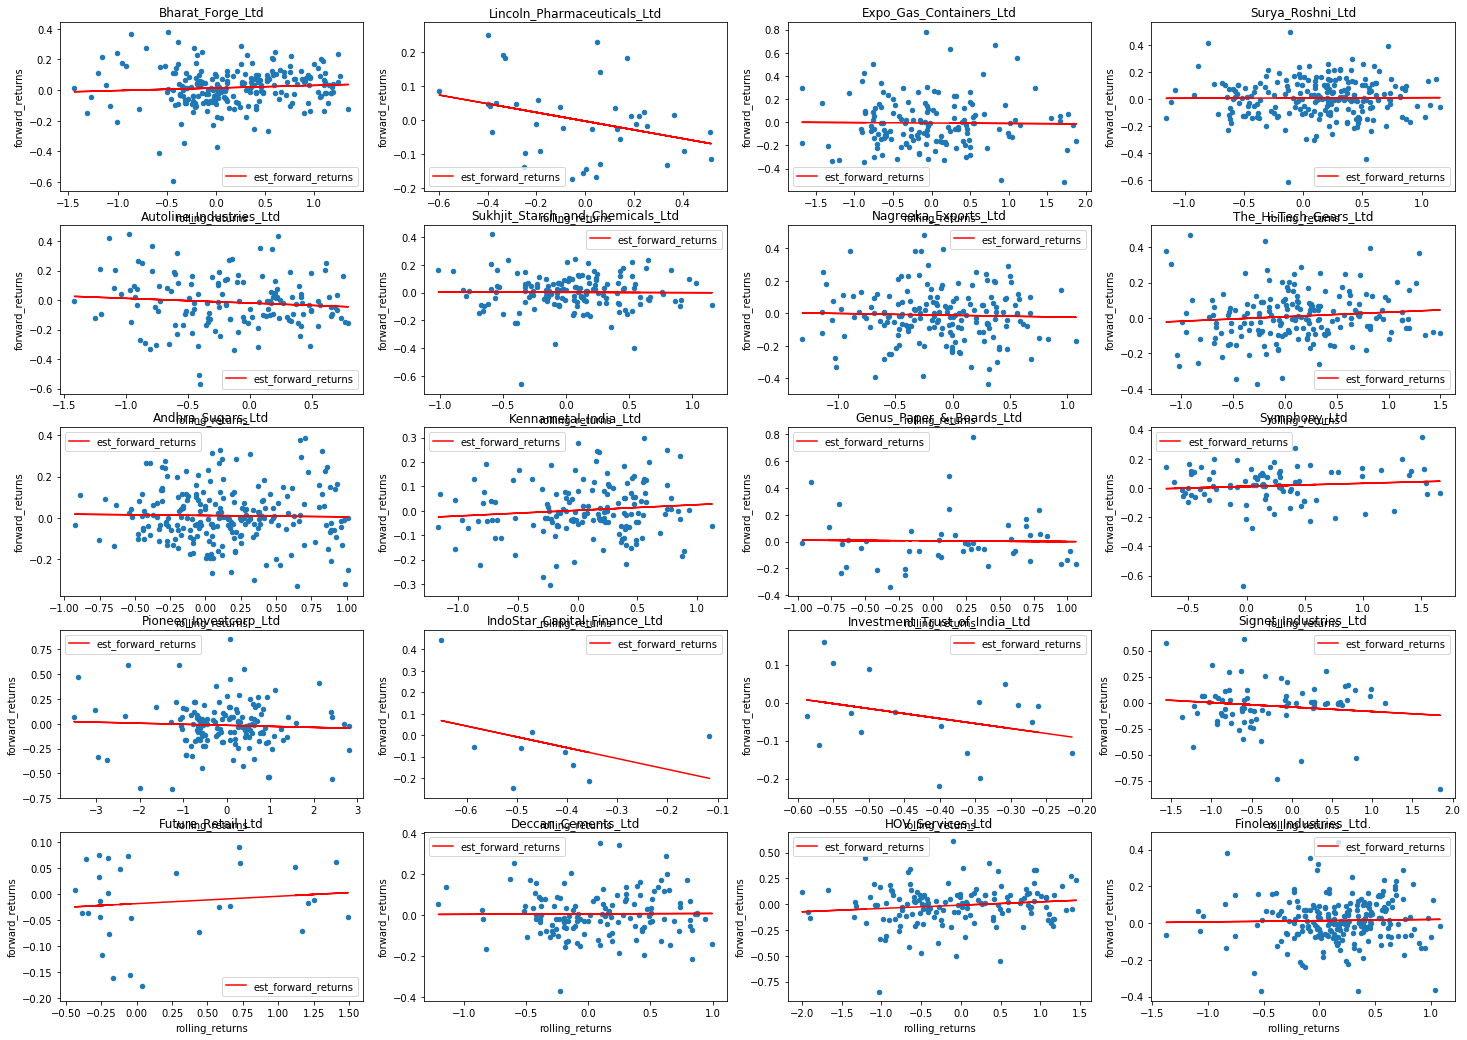

In [207]:
plot_scatter_forward_vs_backward_returns(results, companies_to_be_analysed)

As we can see, in general there is a very slight positive to negative correlation between the two, but it's difficult to say just from the random samples taken. One approach is to actually count the **number of companies which have positive correlation** and derive stats from there. Let's do that now.

In [208]:
### 
### Count number of positive and negative correlations
def count_corr_stats(results):
    c  = 0
    c1 = 0
    for key_t in results:
        if results[key_t]['lr_params'][0] > 0:
            c += 1
        # endif
        if results[key_t]['corr'] > 0:
            c1 += 1
    # endfor
    
    return {'p_pos':c/len(results), 'p_neg':1-c/len(results), 'p_posc':c1/len(results), 'p_negc': 1-c1/len(results)}
# enddef

In [209]:
stats = count_corr_stats(results)
print(stats)

{'p_pos': 0.5079191698525396, 'p_neg': 0.4920808301474604, 'p_posc': 0.5079191698525396, 'p_negc': 0.4920808301474604}


**As we can see, the results are undeterministic.**

Let's see what happens when we try to pedict one month in advance, i.e. introduce a forward_shift of 1. Means, suppose we only take historical returns from February 2019 to February 2018 (i.e. 12 months rolling), but predict the Apr 2019 returns instead of March 2019 returns as we have done just before.

In [210]:
results = analyse_rolling_returns_over_all_assets(cframe, lookback_period=12, forward_period=1, forward_shift=1)

INFO::: Dividing 1832 jobs across 4 threads.
>> Skipping one security due to some internal error.
INFO:: All processes finished !!


>> Companies to be analysed ['Vivimed_Labs_Ltd', 'Samtex_Fashions_Ltd', 'Trident_Ltd', 'Shailja_Commercial_Trade_Frenzy_Ltd', 'Cupid_Ltd', 'Automotive_Stampings_and_Assemblies_Ltd', 'GSS_Infotech_Ltd', 'Kirloskar_Brothers_Ltd', 'Rama_Phosphates_Ltd', 'Padmalaya_Telefilms_Ltd', 'Usha_Martin_Ltd.', 'Himatsingka_Seide_Ltd', 'Isgec_Heavy_Engineering_Ltd', 'Filatex_India_Ltd', 'Unitech_International_Ltd', 'Tata_Communications_Limited', 'Lykis_Ltd', 'Aplaya_Creations_Ltd', 'Dynamic_Industries_Ltd', 'Compuage_Infocom_Ltd']
>> Dataframe for first company "Vivimed_Labs_Ltd""
{'rframe':              returns  rolling_returns  forward_returns  est_forward_returns
t                                                                          
2006-09-30 -0.054479        -1.706245         0.298732            -0.107537
2006-10-31 -0.148942        -1.390781        -0.054479            -0.087018
2006-11-30  0.107782        -1.499202        -0.148942            -0.094070
2006-12-31  0.216106        -1.40634

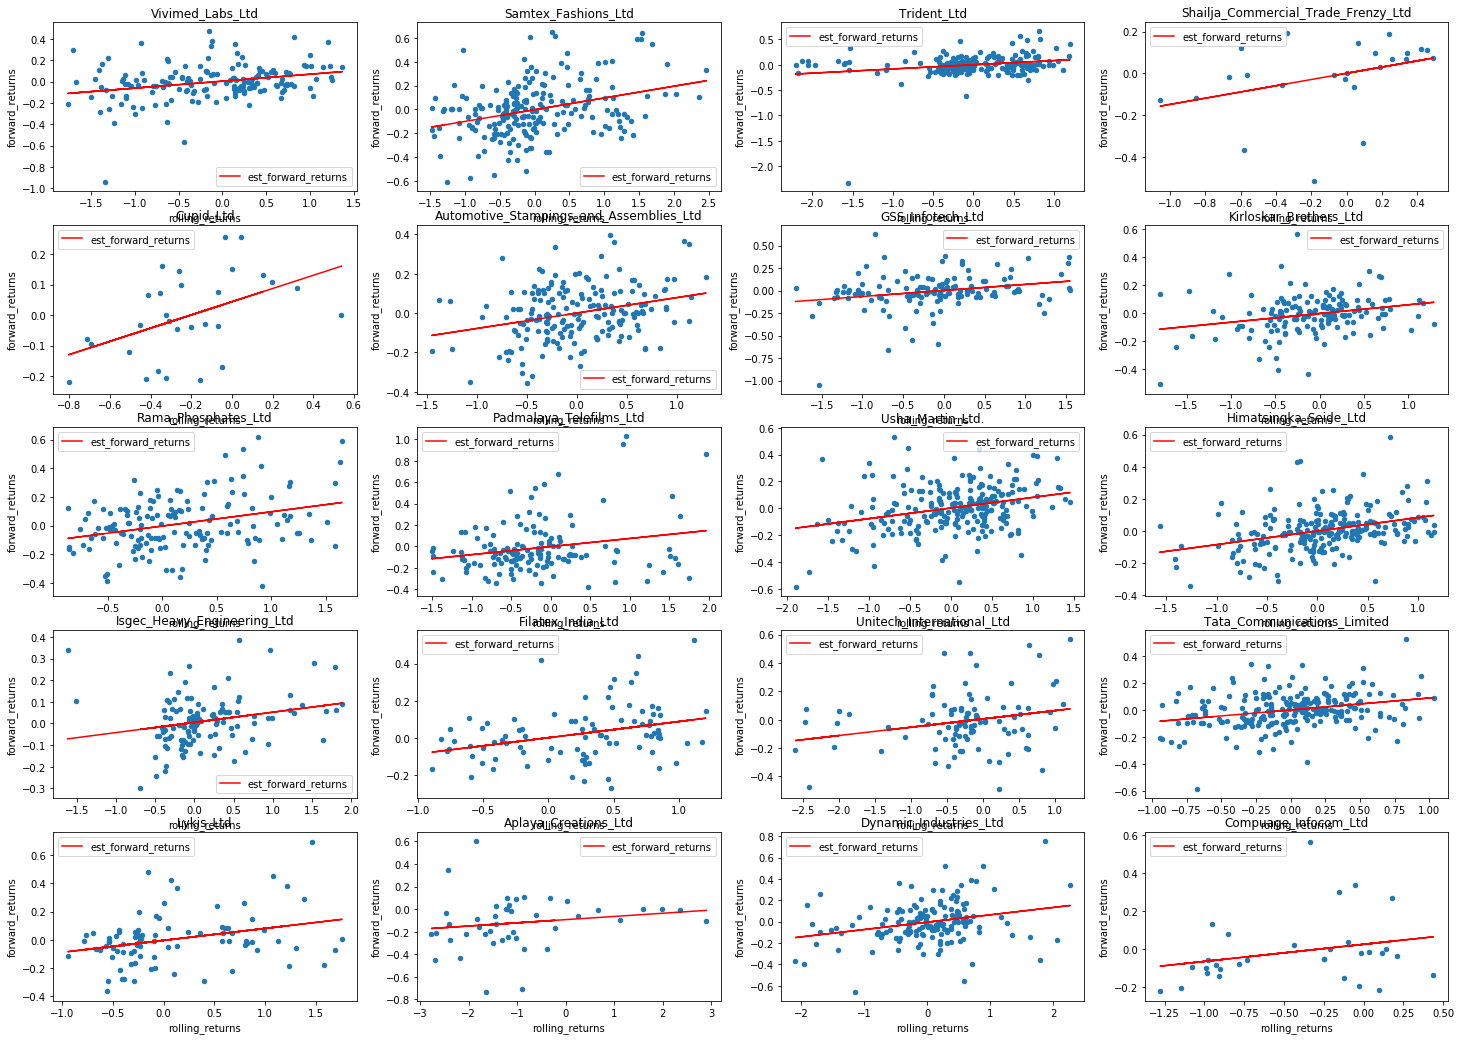

In [211]:
companies_to_be_analysed = select_random_companies(results, 20)
plot_scatter_forward_vs_backward_returns(results, companies_to_be_analysed)
print('combined correlation stats = ', count_corr_stats(results))

As, we can see from the scattter plots above, now we have mostly positive correlation between historical returns and returns for next to next month. Let's try with a forward_shift of 2.

INFO::: Dividing 1832 jobs across 4 threads.
>> Skipping one security due to some internal error.
INFO:: All processes finished !!
>> Companies to be analysed ['SRF_Ltd', 'Simbhaoli_Sugars_Ltd', 'India_Nippon_Electricals_Ltd', 'Kirloskar_Brothers_Ltd', 'Lemon_Tree_Hotels', 'Ashiana_Housing_Ltd', 'Haldyn_Glass_Ltd', 'RSWM_Ltd', '63_Moons_Technologies_Ltd', 'Empower_India_Ltd', 'Cheviot_Co_Ltd', 'Greaves_Cotton_Ltd.', 'MindTree_Ltd', 'Arvind_Ltd.', 'Sudarshan_Chemical_Industries_Ltd', 'Indian_Acrylics_Ltd', 'United_Spirits_Ltd', 'Daikaffil_Chemicals_India_Ltd', 'Viji_Finance_Ltd', 'Balasore_Alloys_Ltd']
>> Dataframe for first company "SRF_Ltd""
{'rframe':              returns  rolling_returns  forward_returns  est_forward_returns
t                                                                          
2001-02-28  0.077159        -0.950976        -0.035480            -0.070823
2001-03-31 -0.252022        -0.717598        -0.169314            -0.052621
2001-04-30 -0.114603        -0.759

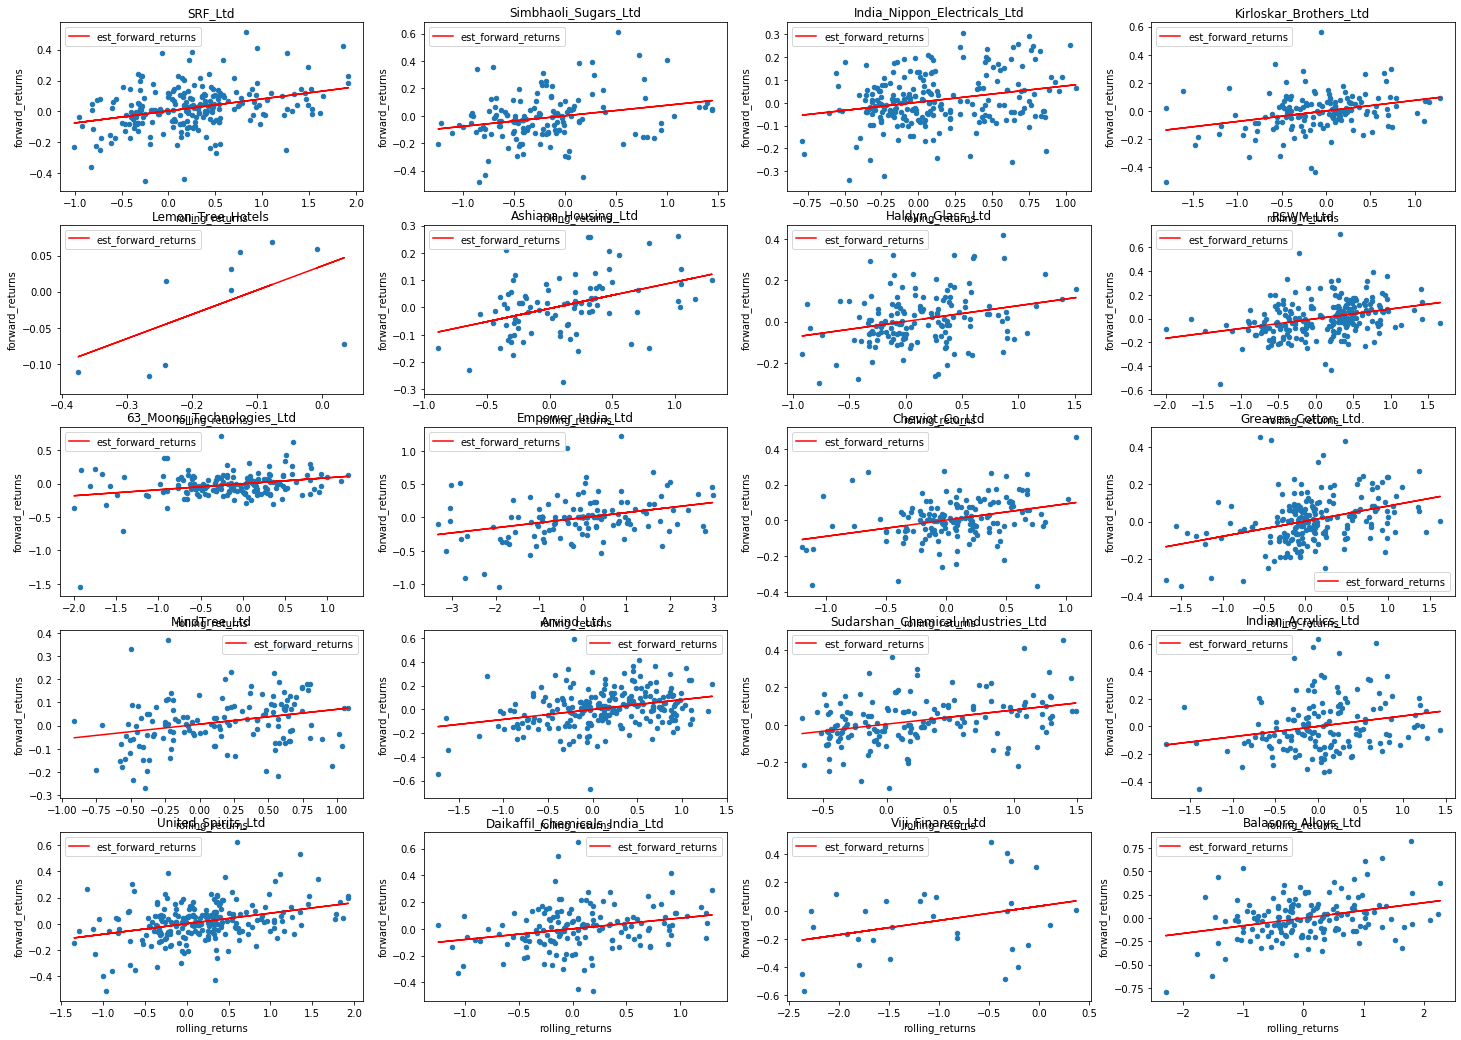

In [213]:
results = analyse_rolling_returns_over_all_assets(cframe, lookback_period=12, forward_period=1, forward_shift=2)
companies_to_be_analysed = select_random_companies(results, 20)
print('combined correlation stats = ', count_corr_stats(results))
plot_scatter_forward_vs_backward_returns(results, companies_to_be_analysed)

Again similar thing. Huge Positive correlation. We will generate a combined matrix of several of these hyper parameters and see how they affect our forecasting ability into the future.


In [216]:
def run_all_cases(cframe, verbose=False):
    backward_periods = [24, 18, 12, 6, 2, 1]
    forward_periods  = [1, 2, 4]
    forward_shift    = [0, 1, 2]
    results_data     = {}

    for backward_period_t in backward_periods:
        for forward_period_t in forward_periods:
            for forward_shift_t in forward_shift:
                if backward_period_t not in results_data:
                    results_data[backward_period_t] = {}
                # endif
                if forward_period_t not in results_data[backward_period_t]:
                    results_data[backward_period_t][forward_period_t] = {}
                # endif
                results_t = analyse_rolling_returns_over_all_assets(cframe, lookback_period=backward_period_t, forward_period=forward_period_t, forward_shift=forward_shift_t, verbose=verbose)
                pcorr_t   = count_corr_stats(results_t)['p_pos']
                results_data[backward_period_t][forward_period_t][forward_shift_t] = pcorr_t
                print('>> Corr (backward_period={}, forward_period={}, forward_shift={}) = {}'.format(backward_period_t, forward_period_t, forward_shift_t, pcorr_t))
            # endfor
        # endfor
    # endfor
    
    return results_data
# enddef

In [217]:
results_matrix = run_all_cases(cframe)

INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=1, forward_shift=0) = 0.33129175946547884
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=1, forward_shift=1) = 0.9576837416481069
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=1, forward_shift=2) = 0.9565701559020044
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=2, forward_shift=0) = 0.9626948775055679
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=2, forward_shift=1) = 0.9526726057906458
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=2, forward_shift=2) = 0.9471046770601337
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=4, forward_shift=0) = 0.9548997772828508
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=4, forward_shift=1) = 0.9521158129175946
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=24, forward_period=4, forward_shift=2) = 0.9543429844097996
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=1, forward_shift=0) = 0.37980241492864986
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=1, forward_shift=1) = 0.9753018660812294
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=1, forward_shift=2) = 0.9747530186608123
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=2, forward_shift=0) = 0.9763995609220637
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=2, forward_shift=1) = 0.9753018660812294
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=2, forward_shift=2) = 0.9731064763995609
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=4, forward_shift=0) = 0.9742041712403952
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=4, forward_shift=1) = 0.9670691547749726
INFO::: Dividing 1832 jobs across 4 threads.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/ipykernel_l

INFO:: All processes finished !!
>> Corr (backward_period=18, forward_period=4, forward_shift=2) = 0.9659714599341384
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=12, forward_period=1, forward_shift=0) = 0.5079191698525396
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=12, forward_period=1, forward_shift=1) = 0.9890770070999454
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=12, forward_period=1, forward_shift=2) = 0.9896231567449482
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=12, forward_period=2, forward_shift=0) = 0.9929000546149646
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=12, forward_period=2, forward_shift=1) = 0.9890770070999454
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes f

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


INFO:: All processes finished !!
>> Corr (backward_period=2, forward_period=2, forward_shift=1) = 0.9983624454148472
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=2, forward_period=2, forward_shift=2) = 0.4959038776624795
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=2, forward_period=4, forward_shift=0) = 0.638995084653195
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=2, forward_period=4, forward_shift=1) = 0.6843255051884216
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=2, forward_period=4, forward_shift=2) = 0.6739486619333698
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=1, forward_shift=0) = 0.5611353711790393
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=2, forward_shift=1) = 0.45524017467248906
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=2, forward_shift=2) = 0.5488803932277444
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=4, forward_shift=0) = 0.6515565264882578
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=4, forward_shift=1) = 0.7056253413435282
INFO::: Dividing 1832 jobs across 4 threads.
INFO:: All processes finished !!
>> Corr (backward_period=1, forward_period=4, forward_shift=2) = 0.604587657018023


It's good to save the positive correlation matrix dictionary, since calculation takes a good amount of time. It's also good to convert it to a proper dataframe, so that it's easy to plot and analyse.

In [220]:
import pickle
pickle.dump(results_matrix, open('data/pcorr_matrix_bse_all_stock_1M.pkl', 'wb'))

In [261]:
def convert_corr_matrix_to_dframe(mat_dict):
    forward_periods   = []
    backward_periods  = []
    forward_shifts    = []
    corr_list         = []
    
    for x in mat_dict:
        for y in mat_dict[x]:
            for z in mat_dict[x][y]:
                backward_periods  += [x]
                forward_periods   += [y]
                forward_shifts    += [z]
                corr_list         += [mat_dict[x][y][z]]
            # endfor
        # endfor
    # endfor
    
    dframe = pd.DataFrame(columns=['backward', 'forward', 'forward_shift', 'pcorrelation'])
    dframe['backward'] = [int(x) for x in backward_periods]
    dframe['forward']  = [int(x) for x in forward_periods]
    dframe['forward_shift'] = [int(x) for x in forward_shifts]
    dframe['pcorrelation'] = corr_list
    
    return dframe
# enddef
    
rmat = convert_corr_matrix_to_dframe(results_matrix)
print(rmat)

    backward  forward  forward_shift  pcorrelation
0         24        1              0      0.331292
1         24        1              1      0.957684
2         24        1              2      0.956570
3         24        2              0      0.962695
4         24        2              1      0.952673
5         24        2              2      0.947105
6         24        4              0      0.954900
7         24        4              1      0.952116
8         24        4              2      0.954343
9         18        1              0      0.379802
10        18        1              1      0.975302
11        18        1              2      0.974753
12        18        2              0      0.976400
13        18        2              1      0.975302
14        18        2              2      0.973106
15        18        4              0      0.974204
16        18        4              1      0.967069
17        18        4              2      0.965971
18        12        1          

Let's generate a scatter plot for the positive correlation probability matrix

In [262]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_scatter(df, x_label, y_label, z_label, c_label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    img = ax.scatter(df[x_label], df[y_label], df[z_label], c=df[c_label], cmap=plt.get_cmap('winter'))
    fig.colorbar(img)
    plt.show()
# enddef

<IPython.core.display.Javascript object>


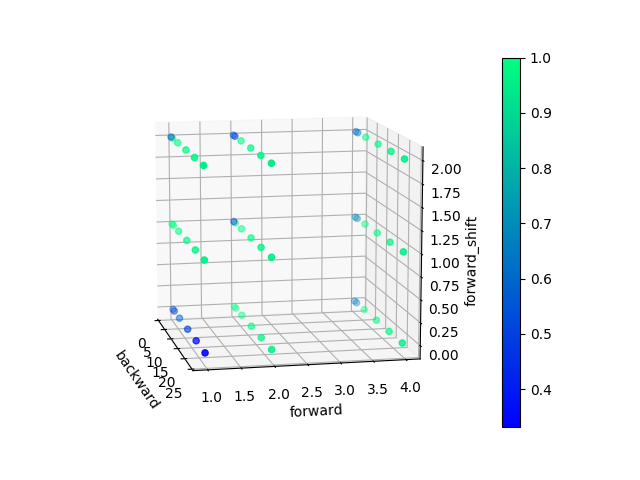

In [263]:
plot_3d_scatter(rmat, 'backward', 'forward', 'forward_shift', 'pcorrelation')

### We can conclude a few things from above scatter plot.

* For **forward_shift=0 and forward_period=1** (i.e. predicting immediate next month return from historical returns), as the lookback period increases, the probability of return for immediate next month being negatively correlated increase more and more.
* For **forward_shift=0 and forward_period>1** (i.e. predicting next *forward_period* month's returns from historical returns), as the lookback period increases, the probability of predicted returns being positively correlated increases more and more.
* For **backward_period=1** (i.e. predicting based on just last month's returns), we have probabilities no better than random guessing. So, effectively it means that **we can't predict just based on last month's returns**.
* Except above cases, most of the correlations seem to have greater chance of being positive.

So, we can conclude from the above analysis that ***prices are mean-reverting in immediate future (next 1 month) but follow trends in intermediate future (next 2-4 months). Immediate past month cannot predict anything effectively, but last 6-12 months have good prediction powers***. Since, we have not analysed forward_periods > 4 months and forward_shifts > 2 (since that's not we are interested in. We are just interesting in predicting returns for future 2-3 months and rebalance the portfolio), we can't say what happens in long term future.

#### NOTE: This was not a backtesting exercise, but more of an analysis on how historical monthly returns dictate future months' returns using historical stock data from BSE (India). We will bother with actual backtesting in some other exercise.